In [1]:
import numpy as np
import pandas as pd
import geopandas
from math import sin, cos, asin, acos, radians
import networkx as nx
from shapely.geometry import LineString
from geopy.distance import distance
import matplotlib.pyplot as plt

import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# Load dataframe
df = pd.read_csv(
    './de.csv', 
    usecols = ['city', 'lat', 'lng', 'population', 'capital', 'admin_name', 'gdp'])


In [3]:
RANDOM_STATE = 4          # For reproducibility
FRACTION_CUSTOMERS = 0.5  # Fraction of cities we want to keep as customers
FRACTION_WAREHOUSES = 0.5 # Fraction of cities we want to keep as warehouse locations
FRACTION_DEMAND = 80    # Fraction of citizens of a city that may order a product  

# List of the 16 regions of germany
REGION_LIST = [
    'Berlin', 'Baden-Württemberg', 'Bavaria', 'Hamburg', 'North Rhine-Westphalia', 'Hesse', 'Saxony', 
    'Bremen', 'Lower Saxony', 'Schleswig-Holstein', 'Saxony-Anhalt', 'Rhineland-Palatinate', 'Thuringia', 'Brandenburg',
    'Saarland', 'Mecklenburg-Western Pomerania']

# Demand is composed of: 
#   1. A fraction of the population
#   2. An error term of uniform distribution
# Note: demand is approximated to the closest int 
# as its physical meaning denies decimals
df['ratio'] = (FRACTION_DEMAND * df['gdp'])/47000

df['demand'] = np.floor(
    0.8 * df['ratio'] * df.population + np.random.uniform(-10, 10, size=(df.shape[0],)))

# Create the warehouses dataframe:
#   1. Filter the 20 regions of Italy
#   2. Filter capitals as candidate warehouse locations
#   3. Sample a fraction of the original cities
facility_df = df.\
                loc[df.admin_name.isin(REGION_LIST)].\
                loc[df.capital.isin(['admin', 'minor'])].\
                sample(frac=FRACTION_WAREHOUSES, random_state=RANDOM_STATE, ignore_index=True)


# Create the salt cavern dataframe:
salt_df = pd.read_csv(
            './salt_locations.csv', 
            usecols = ['city', 'lat', 'lng', 'capacity_kg', 'investment_costs', 'admin_name'])

# Create the customers dataframe:
#   1. Filter the 20 regions of Italy
#   2. Sample a fraction of the original cities
customer_df = df.\
                loc[df.admin_name.isin(REGION_LIST)].\
                sample(frac=FRACTION_CUSTOMERS, random_state=RANDOM_STATE, ignore_index=True)

# Customers IDs list
customer_df['customer_id'] = range(1, 1 + customer_df.shape[0])


In [4]:
def add_geocoordinates(df, lat='lat', lng='lng'):
    '''
    Add column "geometry" with <shapely.geometry.point.Point> objects 
        built from latitude and longitude values in the input dataframe
    
    Args:
        - df: input dataframe
        - lat: name of the column containing the latitude (default: lat)
        - lng: name of the column containing the longitude (default: lng)
    Out:
        - df: same dataframe enriched with a geo-coordinate column
    '''
    assert pd.Series([lat, lng]).isin(df.columns).all(),\
        f'Cannot find columns "{lat}" and/or "{lng}" in the input dataframe.'
    return geopandas.GeoDataFrame(
        df, geometry=geopandas.points_from_xy(df.lng, df.lat))


customer_df = add_geocoordinates(customer_df)
salt_df = add_geocoordinates(salt_df)
facility_df = add_geocoordinates(facility_df)

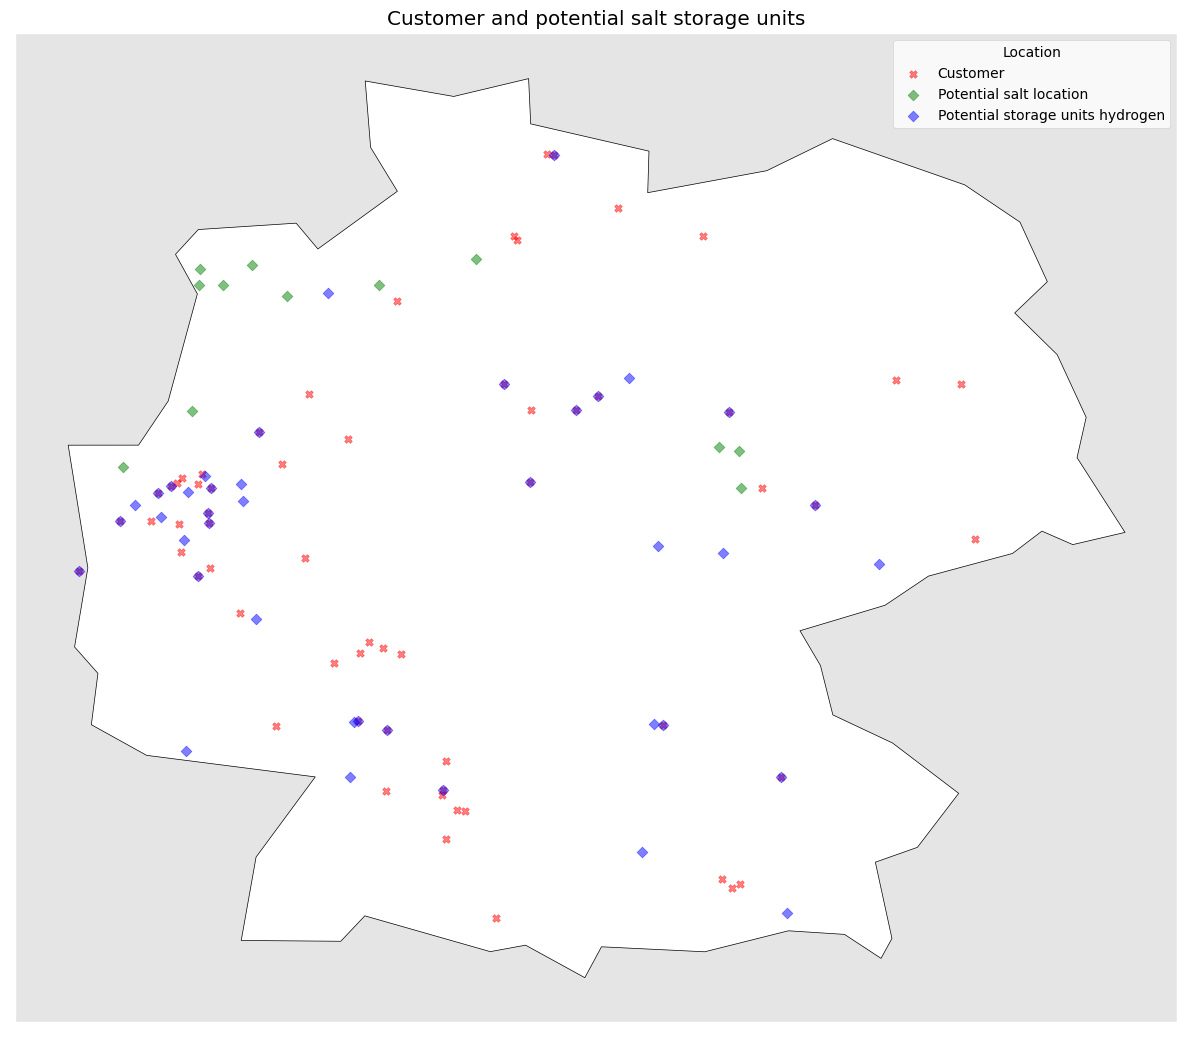

In [5]:
# Prepare country plot
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Extract and plot the shape of Germany
germany = world[world.name == 'Germany']
ax = germany.plot(color='white', edgecolor='black', figsize=(15, 15))

# Plot customers as points
customer_df.\
    plot(ax=ax, marker='X', color='red', markersize=30, alpha=0.5, label='Customer')

# Plot potential facility locations as points
salt_df.\
    plot(ax=ax, marker='D', color='green', markersize=30, alpha=0.5, label='Potential salt location')

# Plot potential facility locations as points
facility_df.\
    plot(ax=ax, marker='D', color='blue', markersize=30, alpha=0.5, label='Potential storage units hydrogen')

# Add legend
plt.legend(facecolor='white', title='Location')

# Add title
plt.title('Customer and potential salt storage units')

# Remove ticks from axis
plt.xticks([])
plt.yticks([])

# Show plot
plt.show()

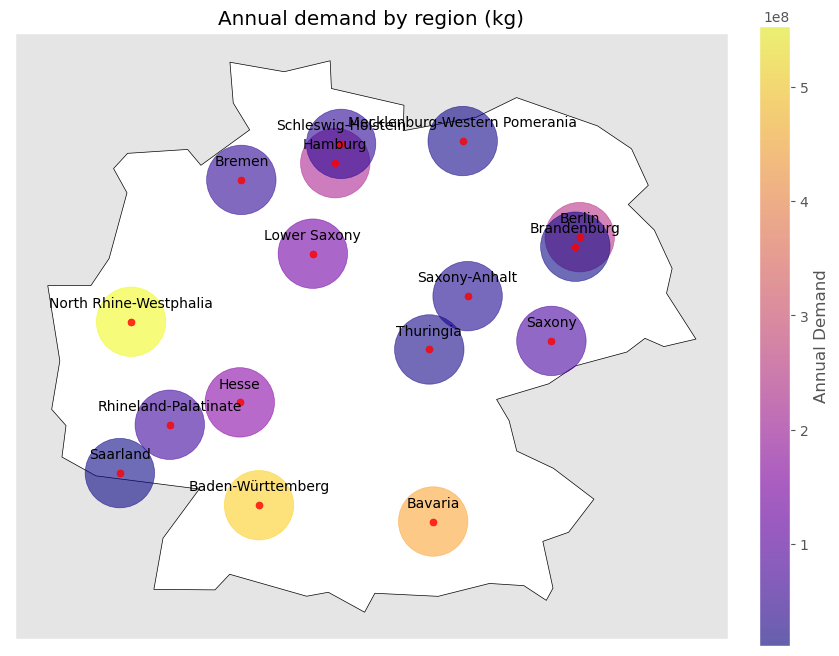

In [6]:
# Prepare region dataframe:
#   1. Filter the 16 regions of germany
#   2. Group by region
#   3. Calculate:
#      - Mean regional latitude
#      - Mean regional longitude
#      - Sum of regional demand
region_df = df.\
             loc[df.admin_name.isin(REGION_LIST)].\
             groupby(['admin_name']).\
             agg({'lat': 'mean', 'lng': 'mean', 'demand': 'sum'}).\
             reset_index()

# Add geo-coordinates
region_df = add_geocoordinates(region_df)

# Plot the shape of gemany
ax = germany.plot(color='white', edgecolor='black', figsize=(10, 10))

# Plot region area colored based on demand
region_df.\
    plot(ax=ax, column='demand', marker='o', c='demand', cmap='plasma', markersize=2500, alpha=0.6)

# Add region 'center' as red dots
region_df.\
    plot(ax=ax, marker='o', c='red', markersize=25, alpha=0.8, label='Customer location')

# Add region name above the center
for i, row in region_df.iterrows():
    plt.annotate(
        row.admin_name, xy=(row.lng, row.lat+0.2), horizontalalignment='center')

# Add color bar with demand scale
plt.colorbar(ax.get_children()[1], ax=ax, label='Annual Demand', fraction=0.04, pad=0.04) 

# Add title
plt.title('Annual demand by region (kg)')

# Remove ticks from axis
plt.xticks([])
plt.yticks([])

# Show plot
plt.show()

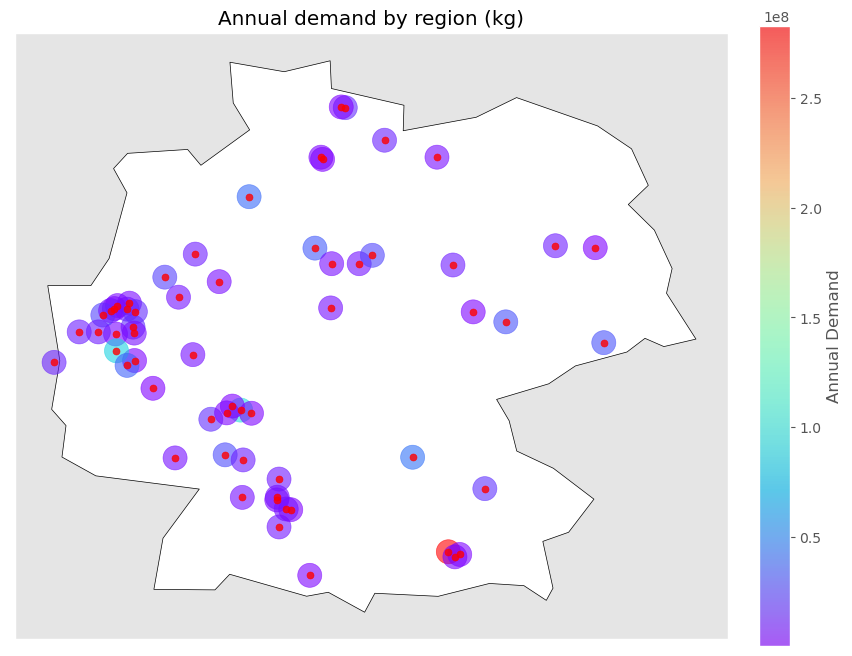

In [7]:
# Plot the shape of gemany
ax = germany.plot(color='white', edgecolor='black', figsize=(10, 10))

# Plot region area colored based on demand
customer_df.\
    plot(ax=ax, column='demand', marker='o', c='demand', cmap='rainbow', markersize=300, alpha=0.6)

# Add region 'center' as red dots
customer_df.\
    plot(ax=ax, marker='o', c='red', markersize=25, alpha=0.8, label='Customer location')

# Add color bar with demand scale
plt.colorbar(ax.get_children()[1], ax=ax, label='Annual Demand', fraction=0.04, pad=0.04) 

# Add title
plt.title('Annual demand by region (kg)')

# Remove ticks from axis
plt.xticks([])
plt.yticks([])

# Show plot
plt.show()

In [8]:
# Dictionary of cutomer id (id) and demand (value)
demand_dict = { customer : customer_df['demand'][i] for i, customer in enumerate(customer_df['customer_id']) }

In [9]:
# Assumptions: 
#    1. Each warehouse has an annual cost of 100.000,00 euros: rent, electricity, ...
#    2. Each warehouse can meet 1 times the regional average annual demand
COST_PER_WAREHOUSE = 1_000_000
SUPPLY_FACTOR_PER_WAREHOUSE = 3
SUPPLY_PER_WAREHOUSE = region_df.demand.mean() * SUPPLY_FACTOR_PER_WAREHOUSE

# Warehouses list
facility_df['warehouse_id'] = ['Warehouse ' + str(i) for i in range(1, 1 + facility_df.shape[0])]

# Dictionary of warehouse id (id) and max supply (value)
annual_supply_dict_facility = { warehouse : SUPPLY_PER_WAREHOUSE for warehouse in facility_df['warehouse_id'] }

# Dictionary of warehouse id (id) and fixed costs (value)
annual_cost_dict_facility = { warehouse : COST_PER_WAREHOUSE for warehouse in facility_df['warehouse_id'] }

In [10]:
# Warehouses list
salt_df['salt_id'] = ['Salt cavern ' + str(i) for i in range(1, 1 + salt_df.shape[0])]

# Dictionary of warehouse id (id) and max supply (value)
annual_supply_dict_salt = { salt : salt_df['capacity_kg'][i] for i, salt in enumerate(salt_df['salt_id']) }

# Dictionary of warehouse id (id) and fixed costs (value)
annual_cost_dict_salt = { salt : salt_df['investment_costs'][i] for i, salt in enumerate(salt_df['salt_id']) }

In [11]:
def haversine_distance(lat1, lon1, lat2, lon2):
    '''
    Calculate distance between two locations given latitude and longitude.

    Args:
       - lat1: latitude of the first location
       - lon1: longitude of the first location
       - lat2: latitude of the second location
       - lon2: longitude of the second location
    Out:
       - Distance in Km
    
    Ref: 
       - https://en.wikipedia.org/wiki/Haversine_formula
    '''
    return 6371.01 *\
            acos(sin(radians(lat1))*sin(radians(lat2)) +\
            cos(radians(lat1))*cos(radians(lat2))*cos(radians(lon1)-radians(lon2)))

In [12]:
def traveling_cost_truck(distance_in_km):
    '''
    Return traveling cost in euros given a distance in Km.

    Args:
      - distance_in_km: travel distance in Km
    Out:
      - cost of the trip in euros
    '''
    return 1.5 * distance_in_km

In [13]:
def traveling_cost_pipeline(distance_in_km):
    '''
    Return traveling cost in euros given a distance in Km.

    Args:
      - distance_in_km: travel distance in Km
    Out:
      - cost of the trip in euros
    '''
    return 0.2 * distance_in_km

In [14]:

# Function to find the location of a specific city
def find_city_location(city_name, city_data):
    # Check if the city exists in the city database
    if city_name in city_data['city'].values:
        # Get the latitude and longitude values for the city
        city_row = city_data[city_data['city'] == city_name].iloc[0]
        city_lat = city_row['lat']
        city_lng = city_row['lng']

        # Find the closest node in the graph
        closest_node = None
        min_distance = float('inf')

        # Iterate over each node in the graph
        for node in G.nodes():
            # Get the latitude and longitude values for the node
            node_lat = G.nodes[node]['lat']
            node_lng = G.nodes[node]['long']

            # Calculate the distance between the node and the city using geopy
            node_location = (node_lat, node_lng)
            city_location = (city_lat, city_lng)
            node_distance = distance(node_location, city_location).km

            # Update the closest node if a shorter distance is found
            if node_distance < min_distance:
                min_distance = node_distance
                closest_node = node

        return closest_node
    else:
        return 'City not found in the city database'



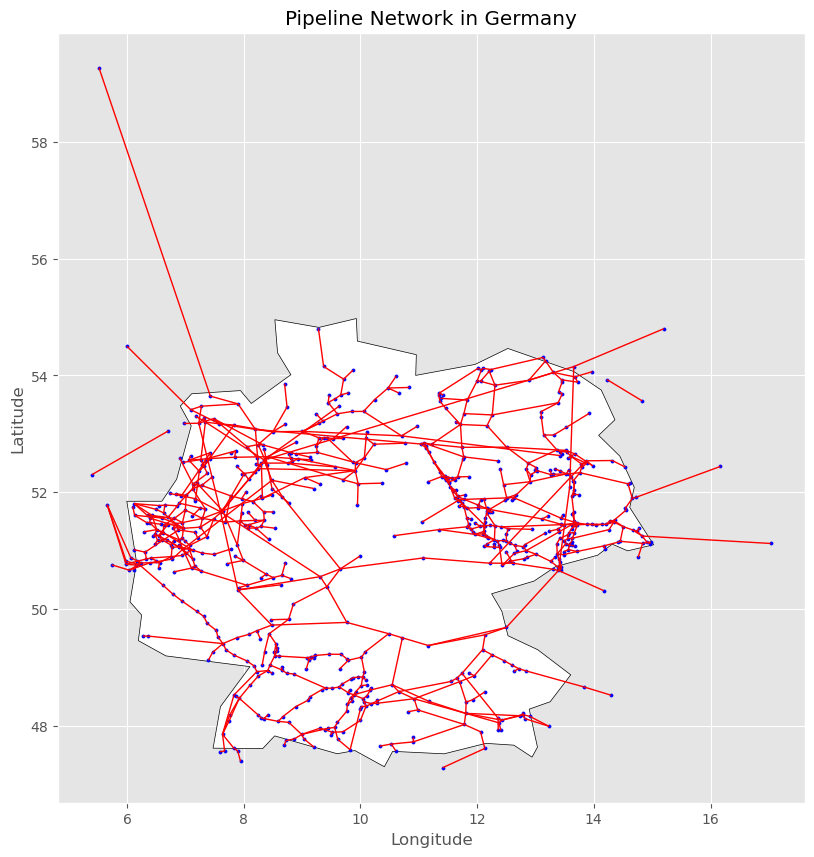

In [15]:
import geopandas as gpd

# Read the pipeline data from a CSV file
pipeline_data = pd.read_csv('LKD_PipeSegments.csv', delimiter=';', usecols=['name', 'node_id', 'lat', 'long'])

# Create an empty graph
G = nx.Graph()

# Iterate over each row in the pipeline data
for index, row in pipeline_data.iterrows():
    node_ids = row['node_id'][1:-1].split(', ')
    latitudes = row['lat'][1:-1].split(', ')
    longitudes = row['long'][1:-1].split(', ')

    # Iterate over each node ID, latitude, and longitude pair
    for i in range(len(node_ids)):
        node_id = node_ids[i][1:-1]  # Remove the square brackets from the node ID
        latitude = float(latitudes[i])
        longitude = float(longitudes[i])

        # Check if the node already exists in the graph
        if not G.has_node(node_id):
            # Add the node to the graph
            G.add_node(node_id)

        # Set latitude and longitude as node attributes
        G.nodes[node_id]['lat'] = latitude
        G.nodes[node_id]['long'] = longitude

        # Calculate the distance between the current node and the next node
        if i < len(node_ids) - 1:
            next_node_id = node_ids[i + 1][1:-1]  # Remove the square brackets from the next node ID
            next_latitude = float(latitudes[i + 1])
            next_longitude = float(longitudes[i + 1])

            # Calculate the distance between the current node and the next node using latitude and longitude
            node_distance = distance((latitude, longitude), (next_latitude, next_longitude)).kilometers

            # Add an edge between the current node and the next node with the distance as an attribute
            G.add_edge(node_id, next_node_id, distance=node_distance)

            # Create a GeoDataFrame from the node attributes in the graph
nodes_df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index', columns=['lat', 'long'])
geometry = gpd.points_from_xy(nodes_df['long'], nodes_df['lat'])
nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry=geometry)

# Create a GeoDataFrame from the edges in the graph
edges_data = []
lines = []
for u, v, data in G.edges(data=True):
    source = nodes_gdf.loc[u, 'geometry']
    target = nodes_gdf.loc[v, 'geometry']
    line = LineString([source, target])
    lines.append(line)
    edges_data.append((u, v, data['distance']))

edges_df = pd.DataFrame(edges_data, columns=['source', 'target', 'distance'])
edges_gdf = gpd.GeoDataFrame(edges_df, geometry=lines)

# Plot the graph
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
germany = world[world['name'] == 'Germany']
fig, ax = plt.subplots(figsize=(10, 10))
germany.plot(ax=ax, color='white', edgecolor='black')
edges_gdf.plot(ax=ax, color='red', linewidth=1)
nodes_gdf.plot(ax=ax, color='blue', markersize=5)
plt.title('Pipeline Network in Germany')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [16]:
def calculate_distance_pipeline(city1_name, database_1, city2_name, database_2):
    closest_node1 = find_city_location(city1_name, database_1)
    closest_node2 = find_city_location(city2_name, database_2)

    shortest_path = nx.shortest_path(G, closest_node1, closest_node2, weight='distance')

    total_distance = sum(G.edges[u, v]['distance'] for u, v in zip(shortest_path[:-1], shortest_path[1:]))

    return total_distance

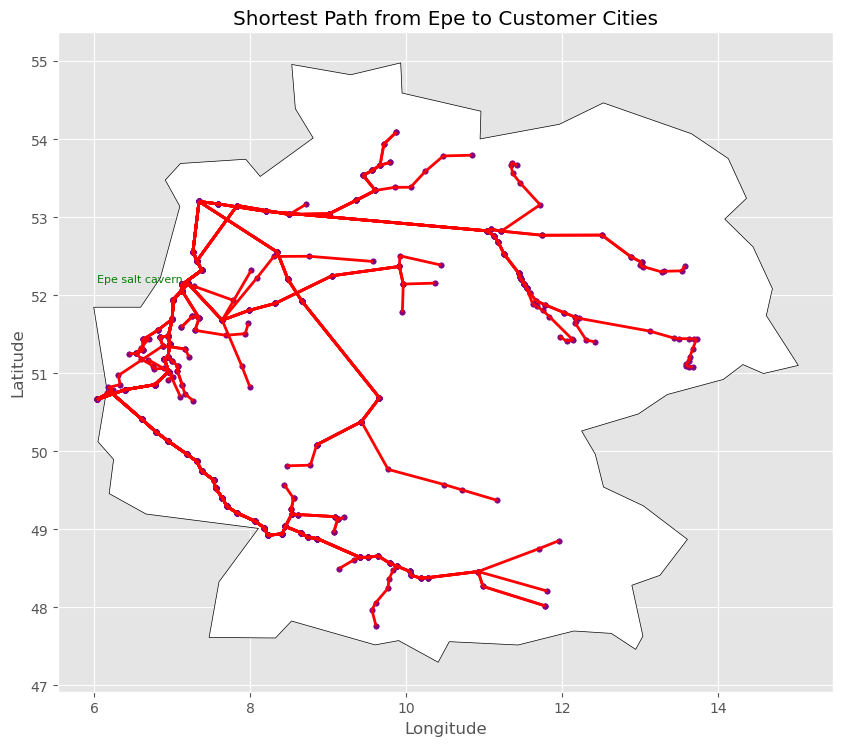

In [17]:
closest_node1 = find_city_location("Epe", salt_df)
customer_cities = customer_df['city'].tolist()

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the graph and nodes
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
germany = world[world['name'] == 'Germany']
germany.plot(ax=ax, color='white', edgecolor='black')

# Iterate over customer cities and plot shortest path from Epe
for city in customer_cities:
    closest_node2 = find_city_location(city, customer_df)
    shortest_path = nx.shortest_path(G, closest_node1, closest_node2, weight='distance')

    # Create a GeoDataFrame for the shortest path nodes
    path_nodes_data = []
    for node in shortest_path:
        geometry = nodes_gdf.loc[node, 'geometry']
        path_nodes_data.append({'geometry': geometry})

    path_nodes_gdf = gpd.GeoDataFrame(path_nodes_data)

    # Create a GeoDataFrame for the shortest path
    path_data = []
    path_lines = []
    for i in range(len(shortest_path) - 1):
        u = shortest_path[i]
        v = shortest_path[i + 1]
        data = G.edges[u, v]
        source = nodes_gdf.loc[u, 'geometry']
        target = nodes_gdf.loc[v, 'geometry']
        line = LineString([source, target])
        path_lines.append(line)
        path_data.append((u, v, data['distance']))

    path_df = pd.DataFrame(path_data, columns=['source', 'target', 'distance'])
    path_gdf = gpd.GeoDataFrame(path_df, geometry=path_lines)

    # Plot the shortest path nodes and path
    path_gdf.plot(ax=ax, color='red', linewidth=2)
    path_nodes_gdf.plot(ax=ax, color='purple', markersize=15)


    # Add city name to the plot
    city_node = nodes_gdf.loc[closest_node2, 'geometry']

# Add start city name to the plot
start_city_name = "Epe salt cavern"
start_node = nodes_gdf.loc[closest_node1, 'geometry']
ax.annotate(start_city_name, (start_node.x, start_node.y), color='green', fontsize=8, ha='right', va='bottom')

plt.title('Shortest Path from Epe to Customer Cities')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [18]:
# Dict to store the distances between all salt location and customers
transport_costs_dict_salt = {}

# For each warehouse location
for i in range(0, salt_df.shape[0]):
    
    # Dict to store the distances between the i-th salt location and all customers
    warehouse_transport_costs_dict = {}
    
    # For each customer location
    for j in range(0, customer_df.shape[0]):
        
        # Distance in Km between warehouse i and customer j
        d = 0 if salt_df.city[i]==customer_df.city[j] else calculate_distance_pipeline(salt_df.city[i], salt_df, customer_df.city[j], customer_df)
        
        # Update costs for warehouse i
        warehouse_transport_costs_dict.update({customer_df.customer_id[j]: traveling_cost_pipeline(d)})
    
    # Final dictionary with all costs for all warehouses
    transport_costs_dict_salt.update({salt_df.salt_id[i]: warehouse_transport_costs_dict})

In [19]:
print(transport_costs_dict_salt)

{'Salt cavern 1': {1: 134.53659817042418, 2: 157.03452677965845, 3: 15.049721395026115, 4: 23.348744410201615, 5: 9.988438991977162, 6: 106.03662602693487, 7: 108.48785968079909, 8: 23.919645322418255, 9: 15.152065588252881, 10: 113.39746747067564, 11: 122.77316710596347, 12: 102.55943718954354, 13: 118.8309221717203, 14: 34.90177255998896, 15: 26.68318587360996, 16: 116.24455698178679, 17: 38.717424937902535, 18: 53.801357561770104, 19: 117.4449341908028, 20: 38.328795421902456, 21: 108.48785968079909, 22: 160.24721414446321, 23: 22.049531558788914, 24: 117.63279003103585, 25: 15.049721395026115, 26: 73.30109354651363, 27: 56.54018132342914, 28: 31.20738252261706, 29: 15.152065588252881, 30: 108.48785968079909, 31: 160.3445145289762, 32: 70.76202188664402, 33: 35.666522648574315, 34: 27.393484902376983, 35: 62.03472991868978, 36: 93.38070180738478, 37: 160.24721414446321, 38: 29.882208583631282, 39: 137.4828067669061, 40: 34.05563391532297, 41: 64.5543537588262, 42: 81.7912636126249, 

In [20]:
# Dict to store the distances between all warehouses and customers
transport_costs_dict_facility = {}

# For each warehouse location
for i in range(0, facility_df.shape[0]):
    
    # Dict to store the distances between the i-th warehouse and all customers
    warehouse_transport_costs_dict = {}
    
    # For each customer location
    for j in range(0, customer_df.shape[0]):
        
        # Distance in Km between warehouse i and customer j
        d = 0 if facility_df.city[i]==customer_df.city[j] else haversine_distance(
            facility_df.lat[i], facility_df.lng[i], customer_df.lat[j], customer_df.lng[j])
        
        # Update costs for warehouse i
        warehouse_transport_costs_dict.update({customer_df.customer_id[j]: traveling_cost_truck(d)})
    
    # Final dictionary with all costs for all warehouses
    transport_costs_dict_facility.update({facility_df.warehouse_id[i]: warehouse_transport_costs_dict})

In [21]:
model = gp.Model('CFLP')

# Variable: y_j (constraint: it is binary): is the facility created
created_facility = {}
for j in facility_df['warehouse_id']:
    created_facility[j] = model.addVar(vtype=GRB.BINARY, name=f'Create_facility_{j}')


# Variable: z_s (constraint: it is binary): is the salt cavern vreated or not
created_salt = {}
for s in salt_df['salt_id']:
    created_salt[s] = model.addVar(vtype=GRB.BINARY, name=f'Create_salt_{s}')

# Variable: x_ij: facility 
served_customer_facility = {}
for i in customer_df['customer_id']:
    for j in facility_df['warehouse_id']:
        served_customer_facility[(i, j)] = model.addVar(lb=0, name=f'Link_{i}_{j}')
        
# Variable: t_ij: salt cavern
served_customer_salt = {}
for i in customer_df['customer_id']:
    for s in salt_df['salt_id']:
        served_customer_salt[(i, s)] = model.addVar(lb=0, name=f'Link_{i}_{s}')


# Objective function
objective = gp.quicksum(annual_cost_dict_facility[j] * created_facility[j] for j in facility_df['warehouse_id']) + \
            gp.quicksum(annual_cost_dict_salt[s] * created_salt[s] for s in salt_df['salt_id']) + \
            gp.quicksum((transport_costs_dict_facility[j][i] + 7) * served_customer_facility[(i, j)] for j in facility_df['warehouse_id'] for i in customer_df['customer_id']) + \
            gp.quicksum((transport_costs_dict_salt[s][i] + 3.8)* served_customer_salt[(i, s)] for s in salt_df['salt_id'] for i in customer_df['customer_id'])
model.setObjective(objective, GRB.MINIMIZE)

# Constraint: the demand must be met
for i in customer_df['customer_id']:
    model.addConstr(gp.quicksum(served_customer_facility[(i, j)] for j in facility_df['warehouse_id']) + \
                    gp.quicksum(served_customer_salt[(i, s)] for s in salt_df['salt_id']) == demand_dict[i])

# Constraint: a warehouse cannot deliver more than its capacity limit
for j in facility_df['warehouse_id']:
    model.addConstr(gp.quicksum(served_customer_facility[(i, j)] for i in customer_df['customer_id']) <= annual_supply_dict_facility[j] * created_facility[j])

# Constraint: a salt cavern cannot deliver more than its capacity limit
for s in salt_df['salt_id']:
    model.addConstr(gp.quicksum(served_customer_salt[(i, s)] for i in customer_df['customer_id']) <= annual_supply_dict_salt[s] * created_salt[s])
                        
# Constraint: a warehouse cannot give a customer more than its demand
for i in customer_df['customer_id']:
    for j in facility_df['warehouse_id']:
        model.addConstr(served_customer_facility[(i, j)] <= demand_dict[i] * created_facility[j])
                        

# Constraint: a warehouse cannot give a customer more than its demand
for i in customer_df['customer_id']:
    for s in salt_df['salt_id']:
        model.addConstr(served_customer_salt[(i, s)] <= demand_dict[i] * created_salt[s])

# Optimize the model
model.optimize()


Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-06
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 5 PRO 5650U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3285 rows, 3224 columns and 12740 nonzeros
Model fingerprint: 0x8823a23c
Variable types: 3172 continuous, 52 integer (52 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+08]
  Objective range  [4e+00, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+05, 3e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 2.842855e+11
Presolve removed 34 rows and 0 columns
Presolve time: 0.03s
Presolved: 3251 rows, 3224 columns, 12672 nonzeros
Variable types: 3172 continuous, 52 integer (52 binary)

Root relaxation: objective 4.660748e+10, 43 itera

In [22]:
# Create dataframe column to store whether to build the warehouse or not
salt_df['build_salt'] = ''

# Assign Yes/No to the dataframe column based on the optimization binary variable
for i in salt_df['salt_id']:
    if created_salt[i].X == 1:
        print('Build site at: ', i)
        salt_df.loc[salt_df['salt_id'] == i, 'build_salt'] = 'Yes'
    else:
        salt_df.loc[salt_df['salt_id'] == i, 'build_salt'] = 'No'

Build site at:  Salt cavern 1
Build site at:  Salt cavern 2
Build site at:  Salt cavern 3
Build site at:  Salt cavern 4
Build site at:  Salt cavern 5
Build site at:  Salt cavern 7
Build site at:  Salt cavern 9
Build site at:  Salt cavern 11
Build site at:  Salt cavern 12


In [23]:
# Create dataframe column to store whether to build the warehouse or not
facility_df['build_warehouse'] = ''

# Assign Yes/No to the dataframe column based on the optimization binary variable
for i in facility_df['warehouse_id']:
    if created_facility[i].X == 1:
        print('Build site at: ', i)
        facility_df.loc[facility_df['warehouse_id'] == i, 'build_warehouse'] = 'Yes'
    else:
        facility_df.loc[facility_df['warehouse_id'] == i, 'build_warehouse'] = 'No'

Build site at:  Warehouse 1
Build site at:  Warehouse 3
Build site at:  Warehouse 5
Build site at:  Warehouse 7
Build site at:  Warehouse 8
Build site at:  Warehouse 9
Build site at:  Warehouse 10
Build site at:  Warehouse 11
Build site at:  Warehouse 12
Build site at:  Warehouse 13
Build site at:  Warehouse 14
Build site at:  Warehouse 15
Build site at:  Warehouse 16
Build site at:  Warehouse 18
Build site at:  Warehouse 20
Build site at:  Warehouse 21
Build site at:  Warehouse 22
Build site at:  Warehouse 25
Build site at:  Warehouse 26
Build site at:  Warehouse 28
Build site at:  Warehouse 30
Build site at:  Warehouse 31
Build site at:  Warehouse 32
Build site at:  Warehouse 33
Build site at:  Warehouse 34
Build site at:  Warehouse 36
Build site at:  Warehouse 38


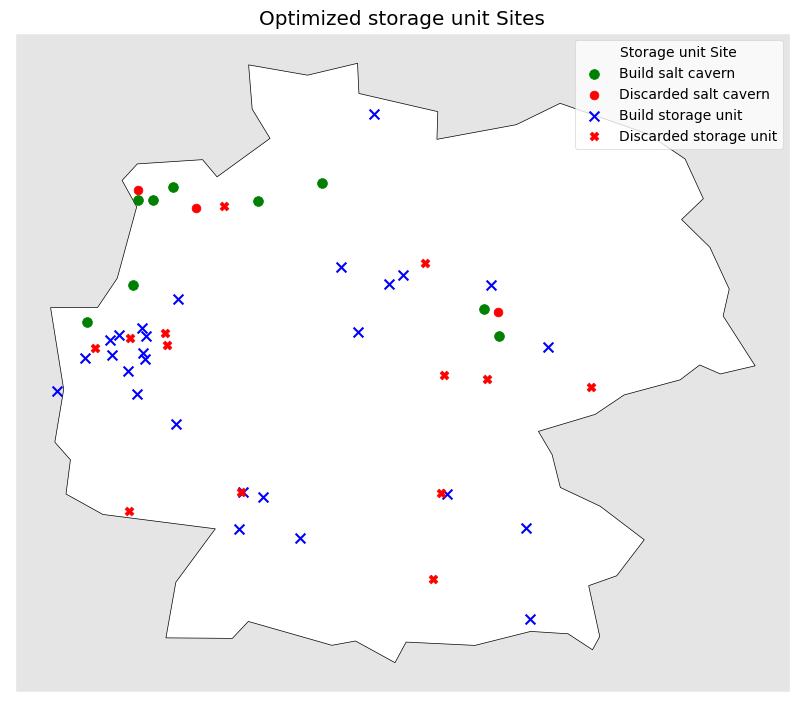

In [24]:
# Plot the shape of germany
ax = germany.plot(color='white', edgecolor='black', figsize=(10, 10))

# Plot sites to establish
salt_df.\
    loc[salt_df.build_salt =='Yes'].\
    plot(ax=ax, marker='o', c='green', markersize=50, label='Build salt cavern')

# Plot sites to discard
salt_df.\
    loc[salt_df.build_salt =='No'].\
    plot(ax=ax, marker='o', c='red', markersize=40, label='Discarded salt cavern')


# Plot sites to establish
facility_df.\
    loc[facility_df.build_warehouse =='Yes'].\
    plot(ax=ax, marker='x', c='blue', markersize=50, label='Build storage unit')

# Plot sites to discard
facility_df.\
    loc[facility_df.build_warehouse =='No'].\
    plot(ax=ax, marker='X', c='red', markersize=40, label='Discarded storage unit')
# Add title
plt.title('Optimized storage unit Sites')

# Add legend
plt.legend(title='Storage unit Site', facecolor='white')

# Remove ticks from axis
plt.xticks([])
plt.yticks([])


# Show plot
plt.show()

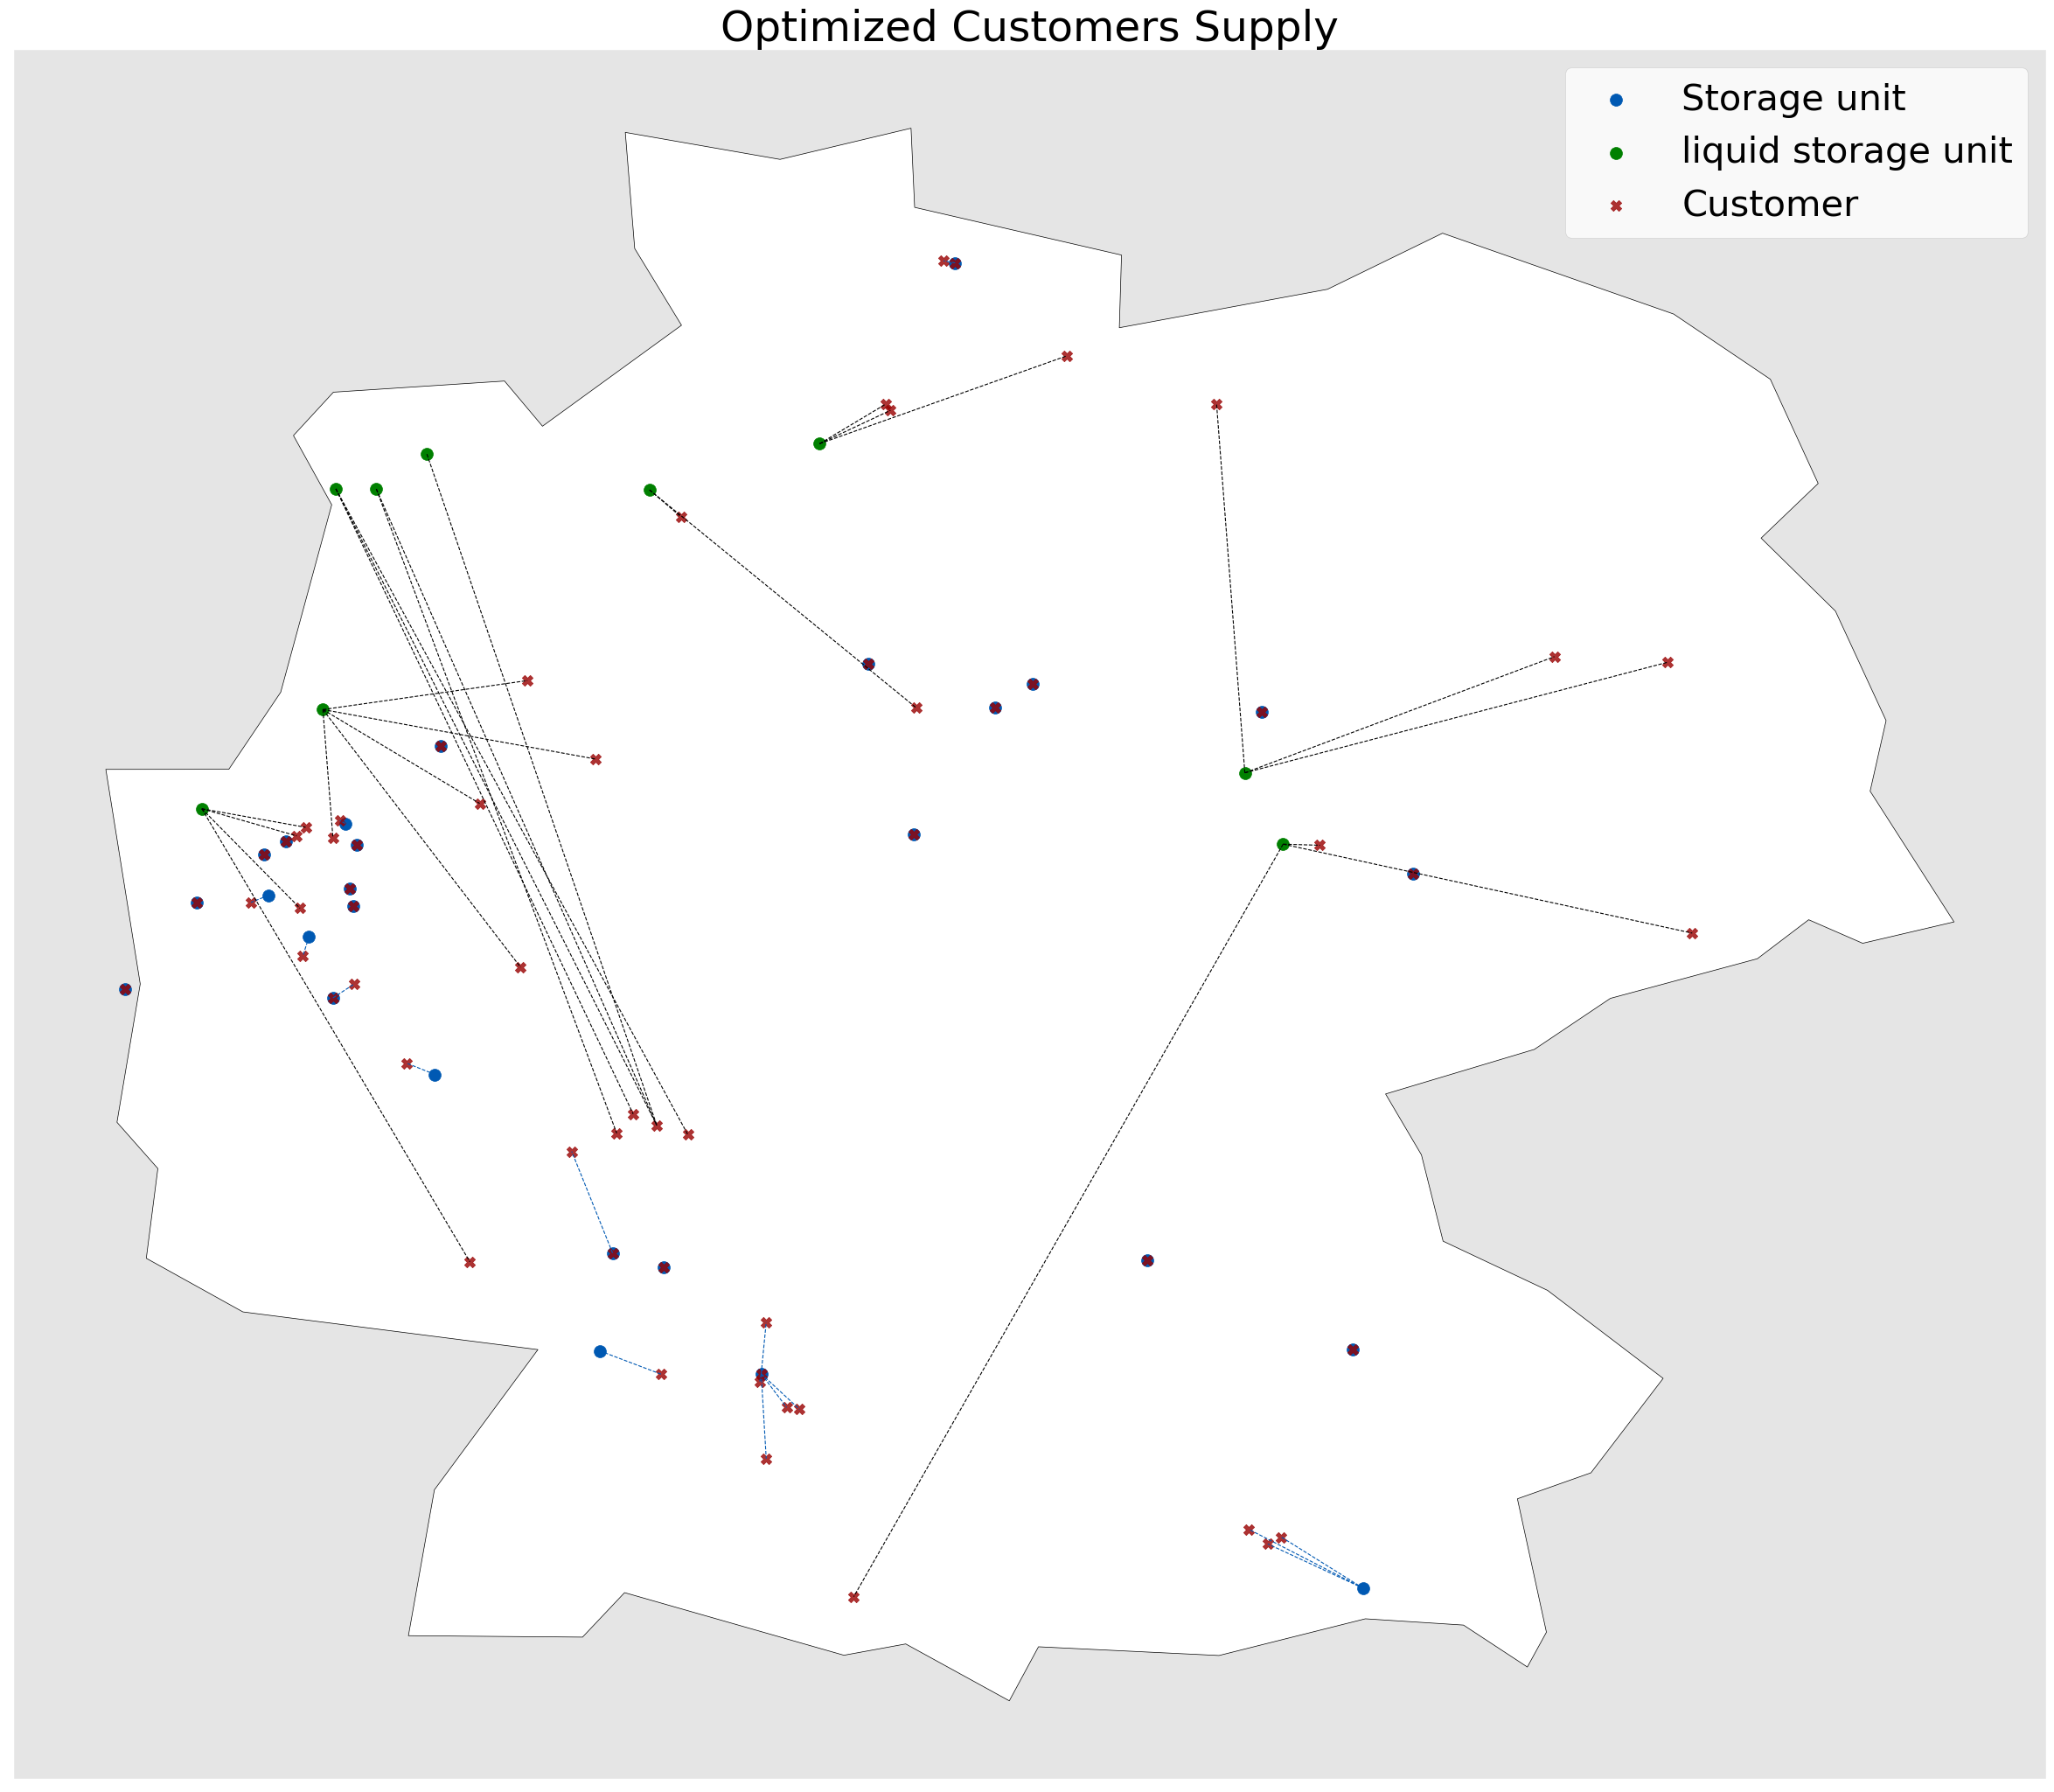

In [25]:
def get_linked_customers(input_warehouse, served_customer):
    '''
    Find customer ids that are served by the input warehouse.

    Args:
        - input_warehouse: string (example: <Warehouse 21>)
    Out:
        - List of customers ids connected to the warehouse
    '''
    # Initialize empty 
    linked_customers = []

    # Iterate through the xij decision variable
    for (i, j) in served_customer.keys():
        # Filter the input warehouse and positive variable values
        if j == input_warehouse and served_customer[(i, j)].X > 0:
            # Customer is served by the input warehouse
            linked_customers.append(i)

    return linked_customers


# Warehouses and salt cavern to establish
establish_facility = facility_df.loc[facility_df['build_warehouse'] == 'Yes']
establish_salt = salt_df.loc[salt_df['build_salt'] == 'Yes']

# Plot the shape of germany
ax = germany.plot(color='white', edgecolor='black', figsize=(30, 30))

# Plot sites to establish
establish_facility.plot(ax=ax, marker='o', c='#0059b3', markersize=100, label='Storage unit')
establish_salt.plot(ax=ax, marker='o', c='green', markersize=100, label='liquid storage unit')


# Plot customers
customer_df.plot(ax=ax, marker='X', color='#990000', markersize=80, alpha=0.8, label='Customer')

# For each warehouse to build
for w in establish_facility['warehouse_id']:
    # Extract list of customers served by the warehouse
    linked_customers = get_linked_customers(w, served_customer_facility)

    # For each served customer
    for c in linked_customers:
        # Plot connection between warehouse and the served customer
        ax.plot(
            [establish_facility.loc[establish_facility['warehouse_id'] == w, 'lng'].values[0], customer_df.loc[customer_df['customer_id'] == c, 'lng'].values[0]],
            [establish_facility.loc[establish_facility['warehouse_id'] == w, 'lat'].values[0], customer_df.loc[customer_df['customer_id'] == c, 'lat'].values[0]],
            linewidth=0.8, linestyle='--', color='#0059b3')
        
for w in establish_salt['salt_id']:
    # Extract list of customers served by the warehouse
    linked_customers = get_linked_customers(w, served_customer_salt)

    # For each served customer
    for c in linked_customers:
        # Plot connection between warehouse and the served customer
        ax.plot(
            [establish_salt.loc[establish_salt['salt_id'] == w, 'lng'].values[0], customer_df.loc[customer_df['customer_id'] == c, 'lng'].values[0]],
            [establish_salt.loc[establish_salt['salt_id'] == w, 'lat'].values[0], customer_df.loc[customer_df['customer_id'] == c, 'lat'].values[0]],
            linewidth=0.8, linestyle='--', color='black')

# Add title
plt.title('Optimized Customers Supply', fontsize=35)

# Add legend
plt.legend(facecolor='white', fontsize=30)

# Remove ticks from axis
plt.xticks([])
plt.yticks([])


# Show plot
plt.show()

C:\Users\Syrine Frini\anaconda3\lib\site-packages\geopandas\plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


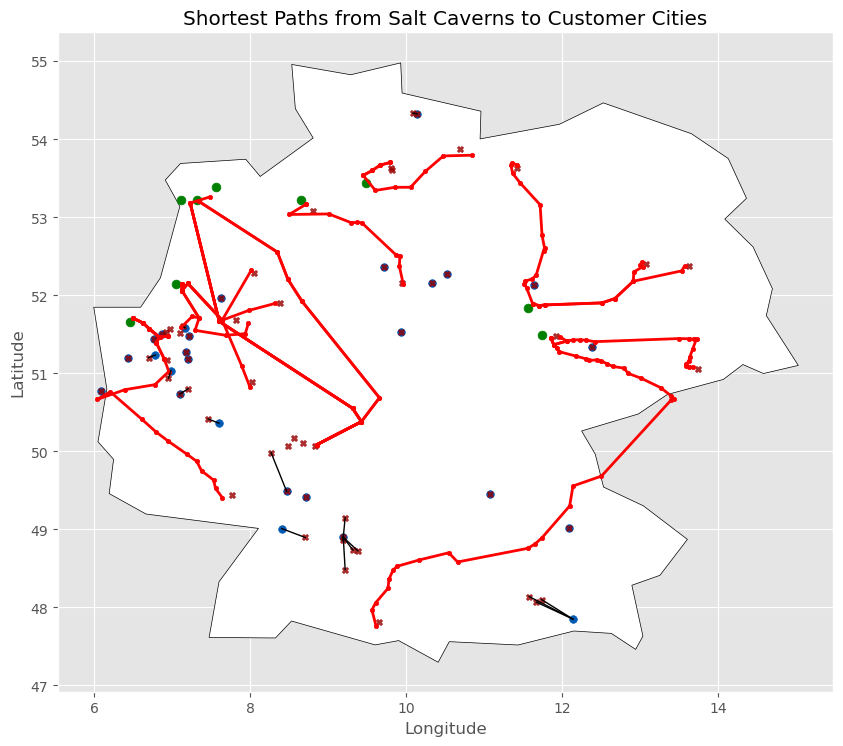

In [26]:
import geopandas as gpd
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the graph and nodes
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
germany = world[world['name'] == 'Germany']
germany.plot(ax=ax, color='white', edgecolor='black')


# Plot sites to establish
establish_facility.plot(ax=ax, marker='o', c='#0059b3', markersize=30, label='Storage unit')
establish_salt.plot(ax=ax, marker='o', c='green', markersize=40, label='Salt cavern')
customer_df.plot(ax=ax, marker='X', color='#990000', markersize=20, alpha=0.8, label='Customer')


# For each warehouse to build
for w in establish_facility['warehouse_id']:
    # Extract list of customers served by the warehouse
    linked_customers = get_linked_customers(w, served_customer_facility)

    # For each served customer
    for c in linked_customers:
        # Plot connection between warehouse and the served customer
        ax.plot(
            [establish_facility.loc[establish_facility['warehouse_id'] == w, 'lng'].values[0], customer_df.loc[customer_df['customer_id'] == c, 'lng'].values[0]],
            [establish_facility.loc[establish_facility['warehouse_id'] == w, 'lat'].values[0], customer_df.loc[customer_df['customer_id'] == c, 'lat'].values[0]],
            linewidth=1, color='black')
            # Plot customers


for w in establish_salt['salt_id']:
    # Extract list of customers served by the warehouse
    linked_customers = get_linked_customers(w, served_customer_salt)

    # For each served customer
    for c in linked_customers:
        closest_node1 = find_city_location(establish_salt.loc[establish_salt['salt_id'] == w, 'city'].values[0], salt_df)
        closest_node2 = find_city_location(customer_df.loc[customer_df['customer_id'] == c, 'city'].values[0], customer_df)

        shortest_path = nx.shortest_path(G, closest_node1, closest_node2, weight='distance')

        # Create a GeoDataFrame for the shortest path nodes
        path_nodes_data = []
        for node in shortest_path:
            geometry = nodes_gdf.loc[node, 'geometry']
            path_nodes_data.append({'geometry': geometry})

        path_nodes_gdf = gpd.GeoDataFrame(path_nodes_data)

        # Create a GeoDataFrame for the shortest path
        path_data = []
        path_lines = []
        for i in range(len(shortest_path) - 1):
            u = shortest_path[i]
            v = shortest_path[i + 1]
            data = G.edges[u, v]
            source = nodes_gdf.loc[u, 'geometry']
            target = nodes_gdf.loc[v, 'geometry']
            line = LineString([source, target])
            path_lines.append(line)
            path_data.append((u, v, data['distance']))

        path_df = pd.DataFrame(path_data, columns=['source', 'target', 'distance'])
        path_gdf = gpd.GeoDataFrame(path_df, geometry=path_lines)

        # Plot the shortest path nodes and path
        path_nodes_gdf.plot(ax=ax, color='red', markersize=10)
        path_gdf.plot(ax=ax, color='red', linewidth=2)



plt.title('Shortest Paths from Salt Caverns to Customer Cities')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
